# Stabilized ICA for transcriptomic data   

In this jupyter notebook, we propose a short example for the use of the algorithm stabilized_ICA.py. We study the extraction of ICA components for a transcriptomic data set gathering NSCLC patients.   

**Note :** To run this jupyter notebook, you first need to extract the data set "data.csv" from the zip file "data.zip" (same directory)

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

## 0. Load the data set

This data set was extraced from ["Defining the Biological Basis of Radiomic Phenotypes in Lung Cancer" Grossman et al. 2017](https://elifesciences.org/articles/23421).   
It contains the expression of 21,766 unique genes for 269 patients with Non-small cell lung cancer (NSCLC) treated at the H. Lee Moffitt Cancer Center, Tampa, Florida, USA. Gene expression values were measured on a custom Rosetta/Merck Affymetrix 2.0 microarray chipset and normalized with the robust multi-array average (RMA) algorithm.

In [10]:
df = pd.read_csv("data.csv" , index_col=0).T
df.head()

,RadioGenomic-017,RadioGenomic-055,RadioGenomic-227,RadioGenomic-222,RadioGenomic-212,RadioGenomic-191,RadioGenomic-259,RadioGenomic-110,RadioGenomic-003,RadioGenomic-034,...,RadioGenomic-261,RadioGenomic-204,RadioGenomic-084,RadioGenomic-232,RadioGenomic-049,RadioGenomic-186,RadioGenomic-134,RadioGenomic-239,RadioGenomic-162,RadioGenomic-179
3643,5.205151,5.615738,5.679276,5.317341,7.196904,5.405730,5.218404,5.607431,6.544434,5.848995,...,5.115181,5.732982,5.713161,5.922955,5.796744,5.620590,5.435381,7.151574,6.706473,6.536985
84263,7.097989,6.585052,7.747854,7.196276,9.346492,7.662668,7.438435,8.463022,7.952210,7.936425,...,7.855756,7.651911,7.621733,7.889039,8.413899,8.264302,7.346372,7.480408,7.967057,7.924989
7171,9.559617,9.777869,10.648704,10.949771,9.673778,10.668188,9.227177,9.696762,10.185486,10.049003,...,9.742841,10.102686,9.533121,11.825210,10.096616,10.297810,10.160288,10.145422,8.893938,11.080574
2934,8.396808,9.082415,9.127985,8.098896,9.358636,8.421808,8.643859,8.445746,9.233013,9.350872,...,7.504968,7.035265,8.551597,8.271226,6.998375,9.346116,8.283634,7.095790,8.356098,8.978290
11052,7.603719,8.639498,7.369421,7.639882,8.741693,8.306786,6.706823,6.024337,6.840010,8.427551,...,6.497460,8.156322,8.075888,7.541231,8.135110,7.826186,7.820982,6.427032,8.622156,7.127454


**Note :** in the following step, we center the expression of each gene (i.e the rows of the dataframe df). Indeed, we noticed that omitting this pre-processing step led to one ICA component entirely driven by the differences between the  mean expression of each gene. This component is not biologically relevant and we avoid it thanks to this centering step.

In [17]:
X = df.apply(func = lambda x : x - x.mean() , axis = 1)

## 1. Most Stable Transcriptome Dimension (MSTD)   

In order to select the number of ICA components we refer to ["Determining the optimal number of independent components for reproducible transcriptomic data analysis" Kairov et al. 2017](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-017-4112-9). The idea is to find a trade-off between a sufficiently large number of components to capture all essential information and a restricted dimension to avoid ending up with a lot of very unstable components which only capture noise.   

To do so we plot the stability distribution for a wide range of different number of components M = 5, ... , 100 and we observe which choice of M most satisfies the trade-off.

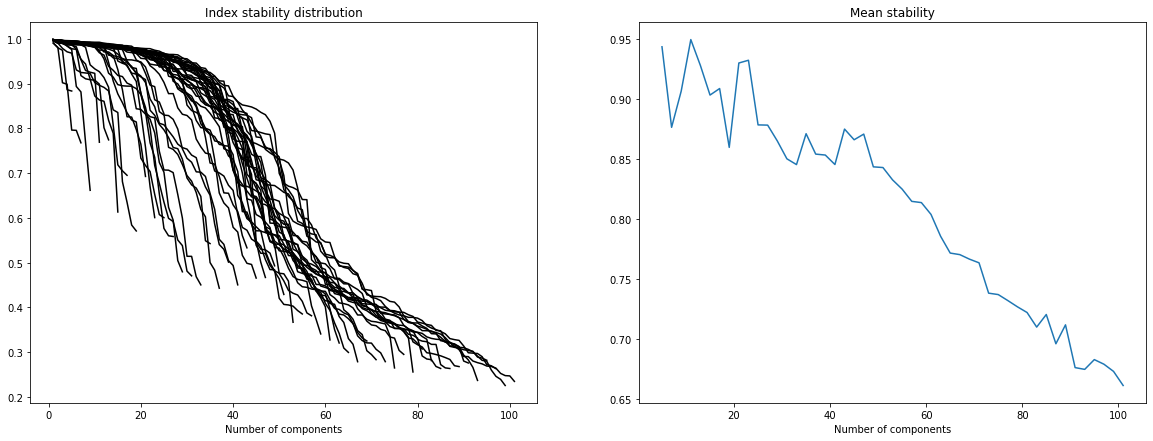

In [12]:
from algorithms.stabilized_ICA import MSTD
MSTD(X , m = 5 , M = 100 , step = 2 , n_runs = 20 , max_iter = 2000)

Please note that in the following we use a rough estimation of the optimal dimension (observed thanks to the graphs above). In fact more sophisticated techniques can be applied to estimate this dimension (ex: two-lines clustering) ; these can be found in the article cited above.

In [3]:
dim_opt = 45

## 2. Stabilized ICA and Multidimensional Scaling (MDS)   

This stabilized ICA algorithm is a copy of the ICASSO algorithm (implemented in MATLAB) (["ICASSO: software for investigating the reliability of ICA estimates by clustering and visualization" Himber et al.](https://www.cs.helsinki.fi/u/ahyvarin/papers/Himberg03.pd) The main idea is to iterate several times the FastICA algorithm (ex: from sklearn), cluster the results (agglomerative hierarchical clustering) and define the final ICA components as the centrotype of each cluster.   

Some explanation for Multidimensional Scaling can be found on the sklearn page : https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html 

In [4]:
from algorithms.stabilized_ICA import StabilizedICA 

running time (min): 00:37.11


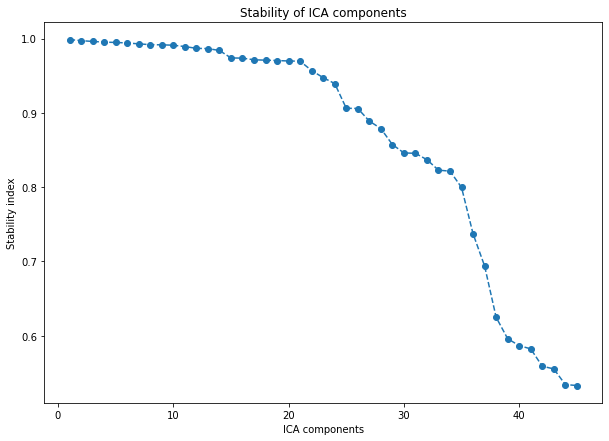

In [18]:
start = time.time()

sICA = StabilizedICA(n_components = dim_opt , max_iter = 2000 , n_jobs = -1)
sICA.fit(X , n_runs = 30 , plot = True ,normalize = True)

end = time.time()

minutes, seconds = divmod(end - start, 60)
print("running time (min): " + "{:0>2}:{:05.2f}".format(int(minutes),seconds))

running time (min): 00:33.06


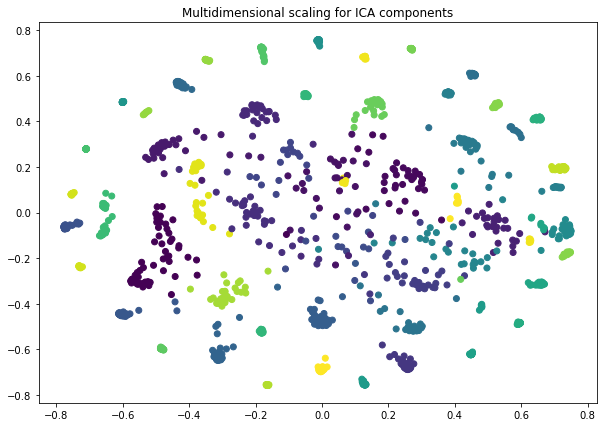

In [19]:
fig , ax = plt.subplots(figsize = (10 , 7))

start = time.time()

sICA.projection(ax = ax , method = 'mds')
ax.set_title("Multidimensional scaling for ICA components")

end = time.time() 

minutes, seconds = divmod(end - start, 60)
print("running time (min): " + "{:0>2}:{:05.2f}".format(int(minutes),seconds))

**Note :** by default, each stabilized ICA component (i.e a row of the S_ matrix) is normalized to unit variance and re-oriented towards positive heaviest tail. These operations facilitate the interpretation of the components and allow us to compare several components from different studies.

In [21]:
Metagenes = pd.DataFrame(sICA.S_ , columns = df.index , index = ['metagene ' + str(i) for i in range(sICA.S_.shape[0])])
Metagenes.head()

,3643,84263,7171,2934,11052,1241,6453,57541,9349,11165,...,643669,1572,8551,26784,26783,26782,26779,26778,26777,100132941
metagene 0,-0.774699,0.109973,0.601553,-0.686361,0.055932,-0.466428,0.061414,0.267063,-0.454384,0.119262,...,0.141473,-0.429170,-1.017428,-0.160173,0.341037,0.084079,-0.661776,-0.161135,-0.032795,-0.278123
metagene 1,0.424265,-0.025497,-0.238358,0.567665,0.514895,0.815033,0.430717,-0.432549,0.716327,-0.011725,...,-0.197169,3.127911,-0.136311,-0.287702,-0.231946,-0.195011,-0.497258,0.215142,0.295947,-0.088971
metagene 2,-0.779481,-0.205259,0.158624,-0.011733,1.130624,0.260571,-0.351422,-0.113934,-2.470609,0.958384,...,-0.721416,-0.867135,-0.440419,-0.005796,0.146072,1.621933,0.408838,0.658533,-0.041077,-0.371293
metagene 3,-0.147822,0.082814,0.539878,1.495771,-0.408263,2.612859,3.492971,0.418490,-1.441521,1.518506,...,0.680904,0.241887,0.664916,-1.408599,-1.100451,0.519214,0.591151,-0.572427,-0.396071,-0.797582
metagene 4,1.438473,-0.508478,-0.333235,-1.180737,0.725694,4.751546,0.426654,-0.439134,-0.701246,-0.037798,...,0.985718,0.145046,0.321464,1.983873,0.721093,1.038491,1.375343,1.173495,0.171394,-0.936318


We can check that we do obtain sparse ICA components by plotting the distribution of "metagene 1" values (i.e the coefficients associated with "metagene 1" for each feature)

Text(0, 0.5, 'Frequency')

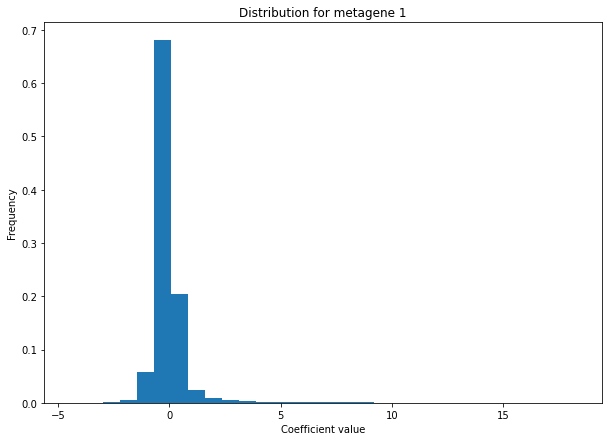

In [22]:
def distribution(Components ,  name , bins):  
    s = Components.loc[name]
    s.hist(bins = bins , weights=np.zeros_like(s) + 1. / s.size , grid = False)
    return

plt.figure(figsize = (10 , 7))
distribution(Metagenes , name = 'metagene 1' , bins = 30)
plt.title("Distribution for metagene 1")
plt.xlabel("Coefficient value")
plt.ylabel("Frequency")